In [2]:
import numpy as np
import numpy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import trigauss
import mesh
import fem

In [3]:
pts, tris, boundaries = mesh.load_mesh('bfs.msh')
pts = pts[:,:2]

A,B,D1,D2,qpts,qtris = fem.assemble_taylor_hood_matrices(pts, tris)

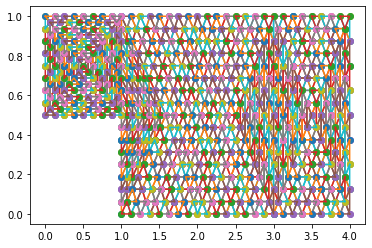

In [4]:
fem.draw_triangles(pts,tris)

In [5]:
from functools import reduce
def union_many(boundaries):
    return reduce(np.union1d, boundaries)

In [6]:
def create_rhs(A, pts, boundary_nodes, boundary_function):
    boundary_values = np.apply_along_axis(boundary_function, 1, pts[boundary_nodes])
    rhs = np.zeros(A.shape[0])
    bcs = np.zeros(A.shape[0])
    
    for i, bc in enumerate(boundary_nodes):
        col = np.array(A[:,bc].todense()).flatten()
        rhs -= col * boundary_values[i]
        bcs[bc] = boundary_values[i]
    
    return rhs, bcs

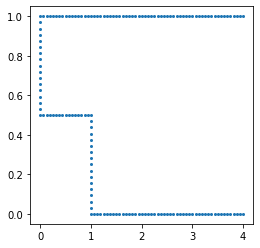

In [11]:
def boundary_nodes(xy):
    x,y=xy
    if x==0:
        return True
    if y==1:
        return True
    if y==0:
        return True
    if y==0.5 and x<= 1:
        return True
    if x==1 and y <= 0.5:
        return True
    return False

dc_nodes = []
for i,q in enumerate(qpts):
    if boundary_nodes(q):
        dc_nodes.append(i)
dc_nodes = np.array(dc_nodes)

R = fem.create_restriction(A.shape[0], dc_nodes)
plt.figure(figsize=(4,4))
plt.plot(qpts[dc_nodes][:,0], qpts[dc_nodes][:,1], 'o', markersize=2)

In [12]:
def boundary_u_x(xy):
    x, y = xy
    if x==0:
        return 1
    return 0

def boundary_u_y(xy):
    return 0

rhs_x, bcs_x = create_rhs(A, qpts, dc_nodes, boundary_u_x)
rhs_y, bcs_y = create_rhs(A, qpts, dc_nodes, boundary_u_y)

In [26]:
import scipy.interpolate as si

def plot_soln_quad(points, triangles, u):
    x = np.linspace(np.min(points[:,0]), np.max(points[:,0]), 300)
    y = np.linspace(np.min(points[:,1]), np.max(points[:,1]), 100)
    xx, yy = np.meshgrid(x,y); xx=xx.flatten(); yy=yy.flatten()
    xi = np.row_stack([xx,yy])
    interpolated = si.griddata(points, u, xi.T, method='cubic')
    domain = np.logical_or(yy > 0.5, xx >= 1)
    plt.scatter(xx[domain],yy[domain], 5, interpolated[domain])

def plot_soln(points, triangles, u):
    plt.tripcolor(points[:,0], points[:,1], triangles, u, shading='gouraud')

In [22]:
Ah = R.T@A@R * 5
Dx = D1@R
Dy = D2@R
Zh = None
Saddle = sp.bmat([
    [Ah,   Zh, -Dx.T],
    [Zh,   Ah, -Dy.T],
    [-Dx, -Dy,    Zh]
]).tocsr()

In [23]:
rhs_p = D1@bcs_x + D2@bcs_y
up = spla.cg(Saddle, np.hstack([R.T@rhs_x, R.T@rhs_y, rhs_p]))[0]

In [24]:
s = (R.T@rhs_x).shape[0]
u_x = R@up[:s] + bcs_x
u_y = R@up[s:2*s] + bcs_y
p = up[2*s:]

Text(0.5, 1.0, 'Pressure')

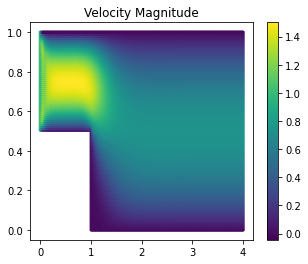

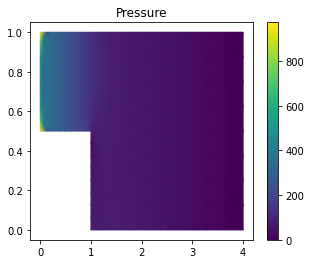

In [27]:
plt.figure(figsize=(5,4))
plot_soln_quad(qpts, qtris, np.sqrt(u_x**2 + u_y**2))
plt.colorbar()
plt.title('Velocity Magnitude')

plt.figure(figsize=(5,4))
plot_soln(pts, tris, p)
plt.colorbar()
plt.title('Pressure')

Text(0.5, 1.0, 'Y Velocity')

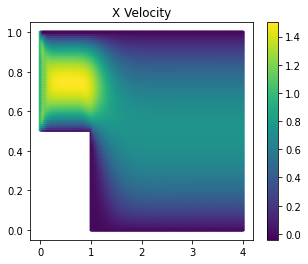

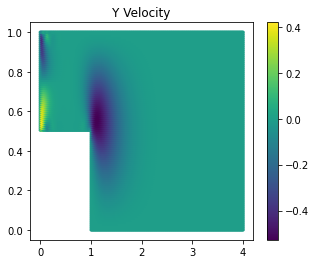

In [28]:
plt.figure(figsize=(5,4))
plot_soln_quad(qpts, qtris, u_x)
plt.colorbar()
plt.title('X Velocity')

plt.figure(figsize=(5,4))
plot_soln_quad(qpts, qtris, u_y)
plt.colorbar()
plt.title('Y Velocity')

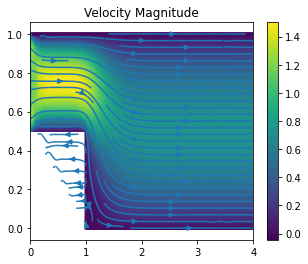

In [29]:
import matplotlib.tri as tri

def plot_streamlines(points, triangles, u_x, u_y):    
    x = np.linspace(np.min(points[:,0]), np.max(points[:,0]), 500)
    y = np.linspace(np.min(points[:,1]), np.max(points[:,1]), 500)
    xx, yy = np.meshgrid(x,y);# xx=xx.flatten(); yy=yy.flatten()
    xi = np.row_stack([xx.flatten(),yy.flatten()])
    u_xi = si.griddata(points, u_x, xi.T, method='cubic')
    u_yi = si.griddata(points, u_y, xi.T, method='cubic')
    plt.streamplot(xx,yy,u_xi.reshape(xx.shape),u_yi.reshape(xx.shape))
    
plt.figure(figsize=(5,4))
plot_soln_quad(qpts, qtris, np.sqrt(u_x**2 + u_y**2))
plt.colorbar()
plt.title('Velocity Magnitude')
plot_streamlines(qpts, qtris, u_x, u_y)